In [3]:
%matplotlib inline

In [4]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score

from helpers import infected_nodes
from graph_helpers import load_graph_by_name
from viz_helpers import lattice_node_pos

In [1]:
graph = 'fb'

dataset_id = '{}-msi-s0.04-o0.1'.format(graph)
cascade_dir = 'cascade/{}'.format(dataset_id)
query_path = 'outputs/queries/{}/loop_erased/'.format(dataset_id)
inf_probas_path = 'outputs/inf_probas/{}/loop_erased/'.format(dataset_id)
fig_root_dir = 'figs/why-random-is-good/{}'.format(dataset_id)

In [5]:
if not os.path.exists(fig_root_dir):
    os.makedirs(fig_root_dir)

In [6]:
g = load_graph_by_name(graph)
if graph == 'lattice-1024':
    pos = lattice_node_pos(g, shape=(32, 32))
else:
    pos = sfdp_layout(g)

In [7]:
def get_performance_scores_over_cascade(num_queries_to_show=25):
    method_names = ['random', 'pagerank', 'entropy', 'prediction_error']    
    records = []
    for cascade_id in range(96):
        r = {}
        cascade_path = os.path.join(cascade_dir, '{}.pkl'.format(cascade_id))
        obs, c = pkl.load(open(cascade_path, 'rb'))
        for method in method_names:
            inf_probas_list = pkl.load(open(inf_probas_path + method + '/{}.pkl'.format(cascade_id), 'rb'))
            queries, _ = pkl.load(open(query_path + method + '/{}.pkl'.format(cascade_id), 'rb'))

            known_nodes = set(list(obs) + queries[:num_queries_to_show])
            mask = np.array([(i not in known_nodes) for i in range(len(c))])
            
            inf_nodes = infected_nodes(c)
            y_true = np.zeros((len(c), ))
            y_true[inf_nodes] = 1

            score = average_precision_score(y_true[mask], inf_probas_list[num_queries_to_show-1][mask])
            r[method] = score
        records.append(r)
    df = pd.DataFrame.from_records(records)
    return df

perf = get_performance_scores_over_cascade()

# the cascade that random gives the largest peformance advantage over prediction error
diff = (perf['random'] - perf['prediction_error'])
random_best_cascade_id = diff.argmax()
print('random best performance diff {} w.r.t cascade {}'.format(diff.max(), random_best_cascade_id))

# the cascade that prediction gives the largest peformance advantage over random
diff = (perf['prediction_error'] - perf['random'])
prederror_best_cascade_id = diff.argmax()
print('prederror best performance diff {} w.r.t cascade {}'.format(diff.max(), prederror_best_cascade_id))

# the cascade that prediction error and random gives the most similar performance
similar_cascade_id = diff.abs().argmin()
print('prederror best performance diff {} w.r.t cascade {}'.format(diff.abs().min(), similar_cascade_id))


random best performance diff 0.08271531552528133 w.r.t cascade 35
prederror best performance diff 0.06838769009044676 w.r.t cascade 93
prederror best performance diff 0.0001670597284522124 w.r.t cascade 52


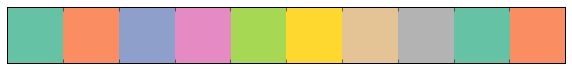

In [20]:
# color related

DEFAULT_COLOR_ID = 7
OBS_COLOR_ID = 4
QUERY_COLOR_ID = 1

DEFAULT_NODE_SIZE = 2.5
OBS_NODE_SIZE = 5
QUERY_NODE_SIZE = 10

pal = sns.color_palette("Set2", 10)
sns.palplot(pal)

def init_node_color(g):
    color = g.new_vertex_property('vector<double>')
    for v in g.vertices():
        color[v] = pal[DEFAULT_COLOR_ID] + (1,)
    return color

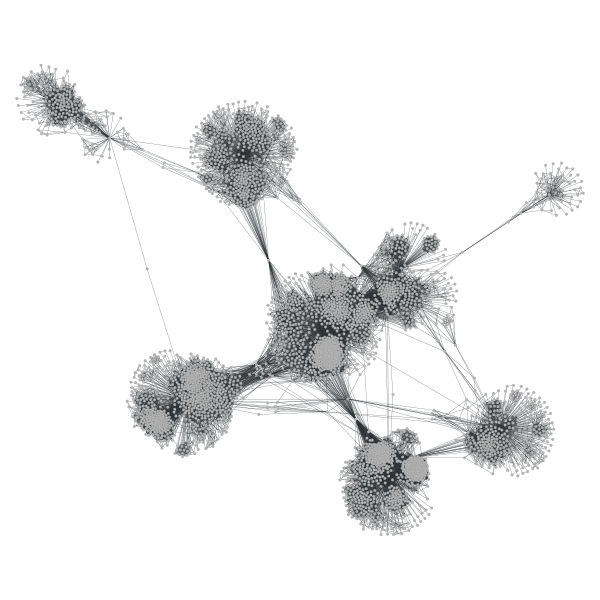

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f083d24f400, at 0x7f0894b2ce10>

In [9]:
color = init_node_color(g)
graph_draw(g, pos=pos, vertex_fill_color=color, output=fig_root_dir+'/graph.png')

In [21]:
def illustrate(cascade_id, fig_subdir, num_queries_to_show=25):
    fig_dir = os.path.join(fig_root_dir, fig_subdir)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
        
    cascade_path = 'cascade/{}/{}.pkl'.format(dataset_id, cascade_id)
    print('cascade path', cascade_path)
    obs, c = pkl.load(open(cascade_path, 'rb'))
    inf_nodes = infected_nodes(c)

    print('{:.2f} % of the nodes are infected'.format(len(inf_nodes) / g.num_vertices() *100))

    # plot the cascade
    node_color = init_node_color(g)
    for v in (c >= 0).nonzero()[0]:
        node_color[v] = pal[OBS_COLOR_ID] + (1, )

    vertex_size = g.new_vertex_property('int')
    vertex_size.a[c < 0] = DEFAULT_NODE_SIZE
    vertex_size.a[c >= 0] = OBS_NODE_SIZE

    graph_draw(g, pos=pos, vertex_fill_color=node_color, vertex_size=vertex_size,
               output=fig_dir+'/cascade.png')
    
    # plot the observation
    node_color = init_node_color(g)
    for v in obs:
        node_color[v] = pal[OBS_COLOR_ID] + (1, )


    vertex_size = g.new_vertex_property('int')
    vertex_size.a = DEFAULT_NODE_SIZE
    vertex_size.a[obs] = OBS_NODE_SIZE

    graph_draw(g, pos=pos,
               vertex_fill_color=node_color,
               vertex_size=vertex_size,
               output=fig_dir+'/observation.png') 
    
    
    # plot the queries for each method
    random_queries, _ = pkl.load(open(query_path + 'random/{}.pkl'.format(cascade_id), 'rb'))
    entropy_queries, _ = pkl.load(open(query_path + 'entropy/{}.pkl'.format(cascade_id), 'rb'))
    pagerank_queries, _ = pkl.load(open(query_path + 'pagerank/{}.pkl'.format(cascade_id), 'rb'))
    prederror_queries, _ = pkl.load(open(query_path + 'prediction_error/{}.pkl'.format(cascade_id), 'rb'))    
    
    def show_queries(g, pos, obs, queries, name):
        node_color = init_node_color(g)
        for v in obs:
            node_color[v] = pal[OBS_COLOR_ID] + (1, )
        for v in queries:
            node_color[v] = pal[QUERY_COLOR_ID] + (1,)

        vertex_size = g.new_vertex_property('int')
        vertex_size.a = DEFAULT_NODE_SIZE
        vertex_size.a[obs] = OBS_NODE_SIZE
        vertex_size.a[queries] = QUERY_NODE_SIZE

        graph_draw(g, pos=pos,
                   vertex_fill_color=node_color,
                   vertex_size=vertex_size,
                   output=fig_dir+'/queries_by_{}.png'.format(name))
        
    show_queries(g, pos, obs, random_queries[:num_queries_to_show], 'random')
    show_queries(g, pos, obs, prederror_queries[:num_queries_to_show], 'prediction_error')
    show_queries(g, pos, obs, entropy_queries[:num_queries_to_show], 'entropy')
    show_queries(g, pos, obs, pagerank_queries[:num_queries_to_show], 'pagerank')        

cascade path cascade/fb-msi-s0.04-o0.1/35.pkl
4.33 % of the nodes are infected


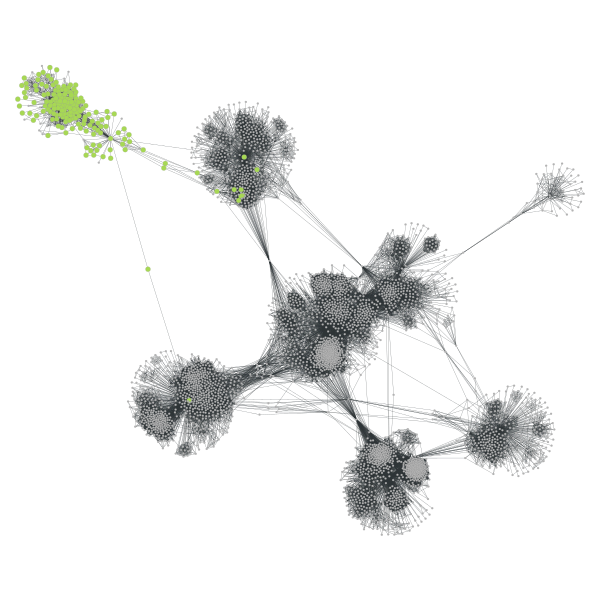

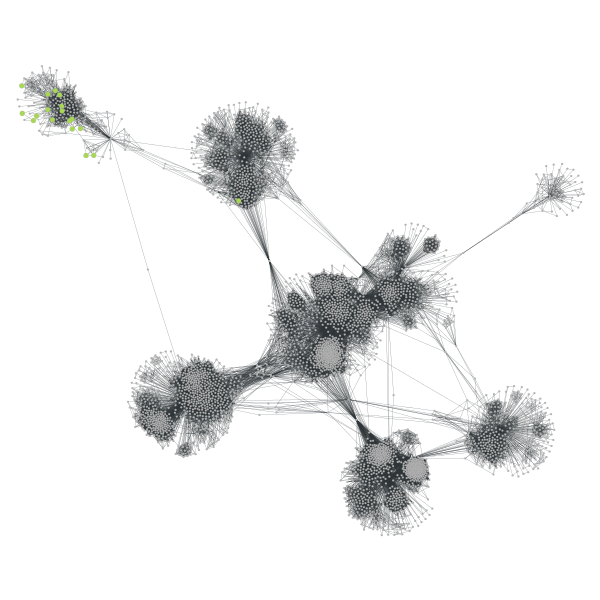

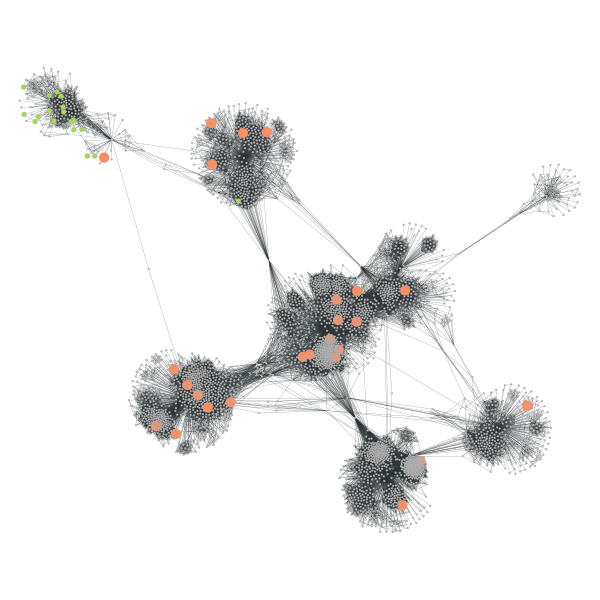

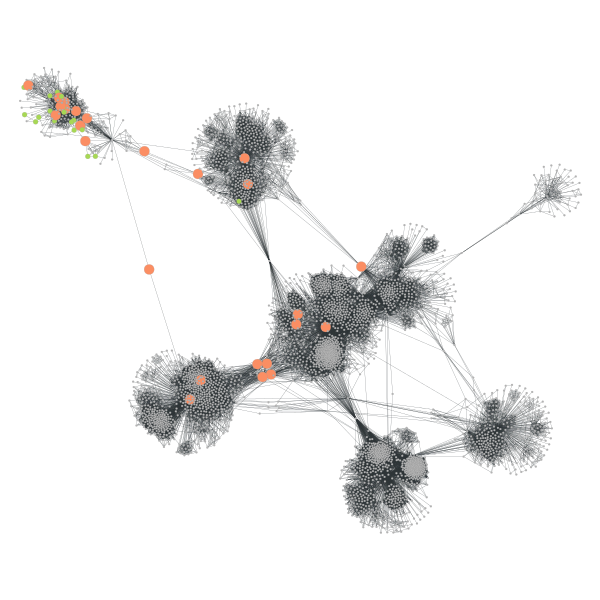

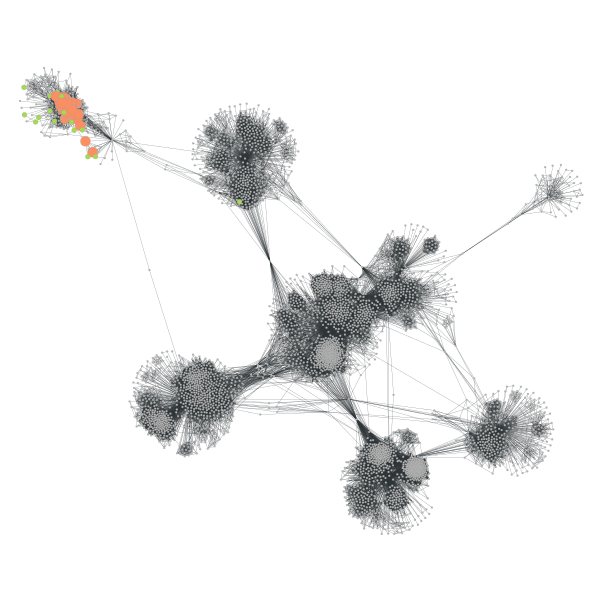

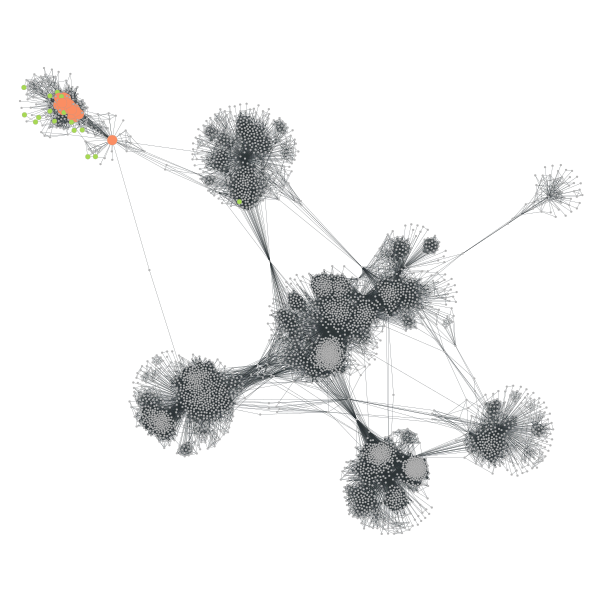

cascade path cascade/fb-msi-s0.04-o0.1/93.pkl
4.56 % of the nodes are infected


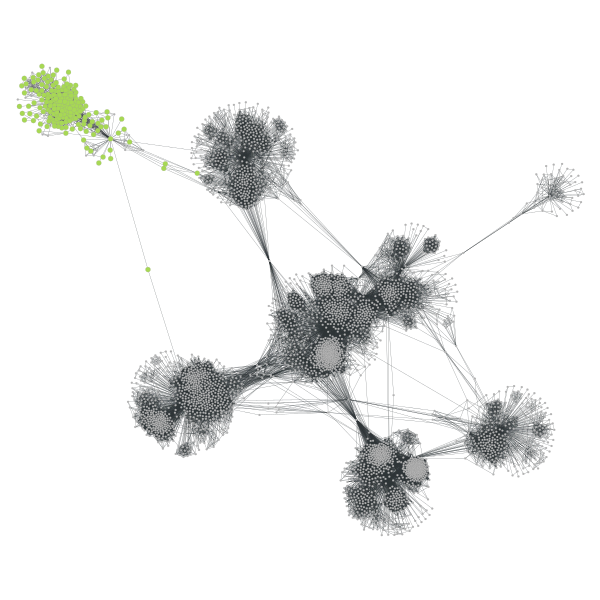

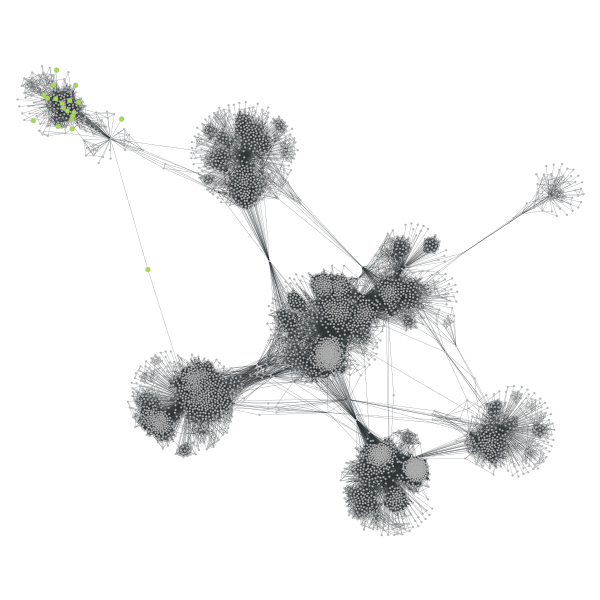

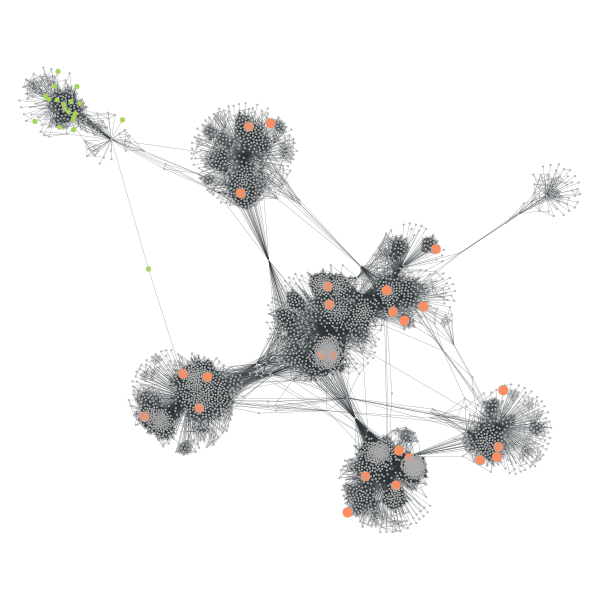

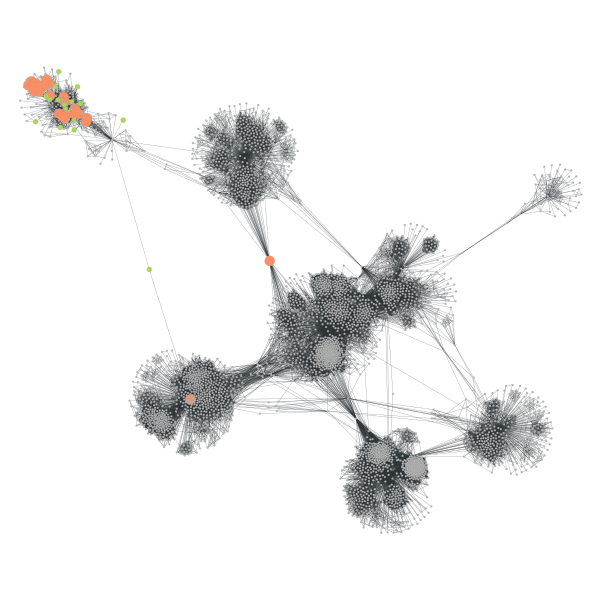

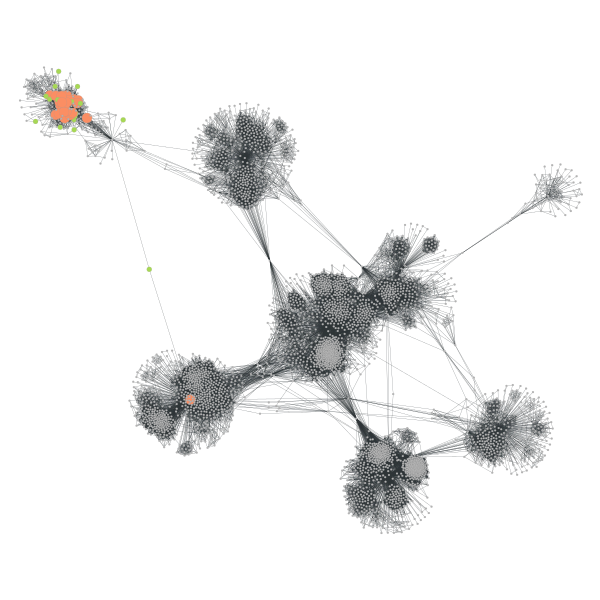

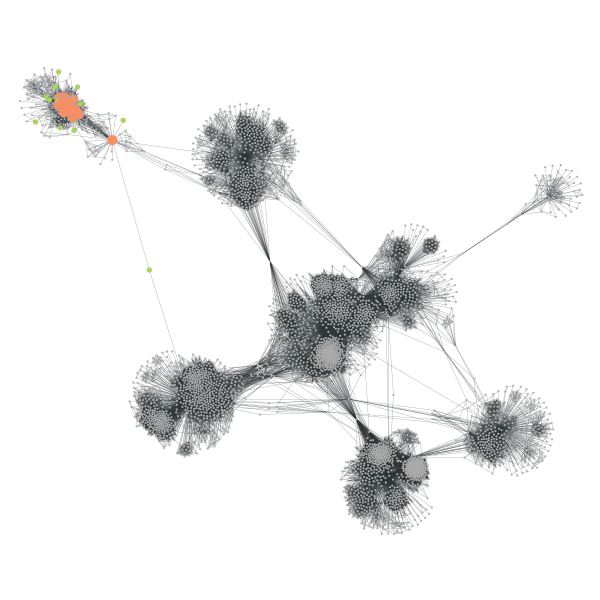

cascade path cascade/fb-msi-s0.04-o0.1/52.pkl
12.55 % of the nodes are infected


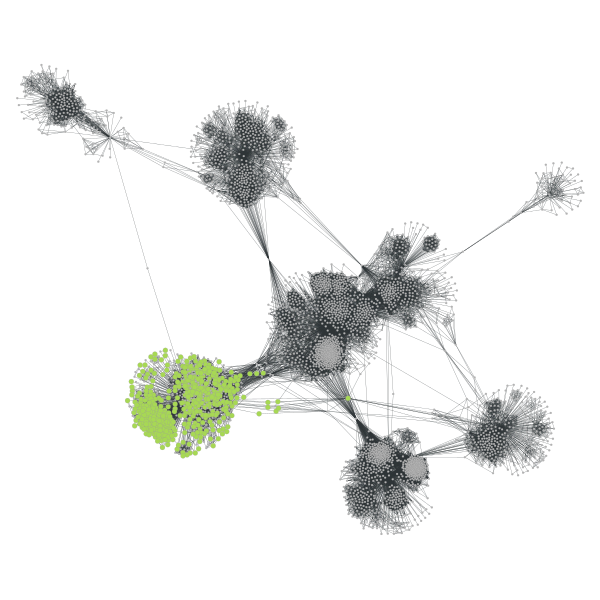

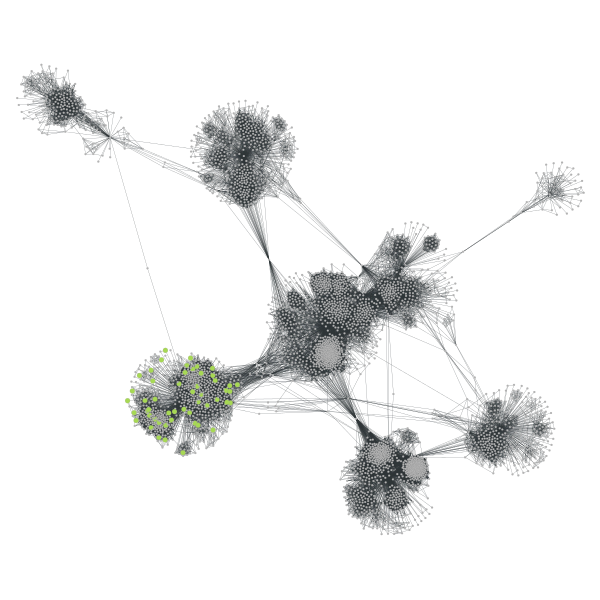

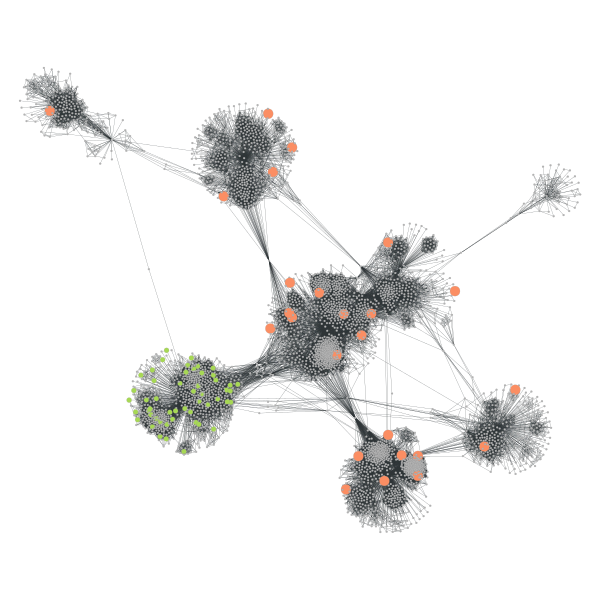

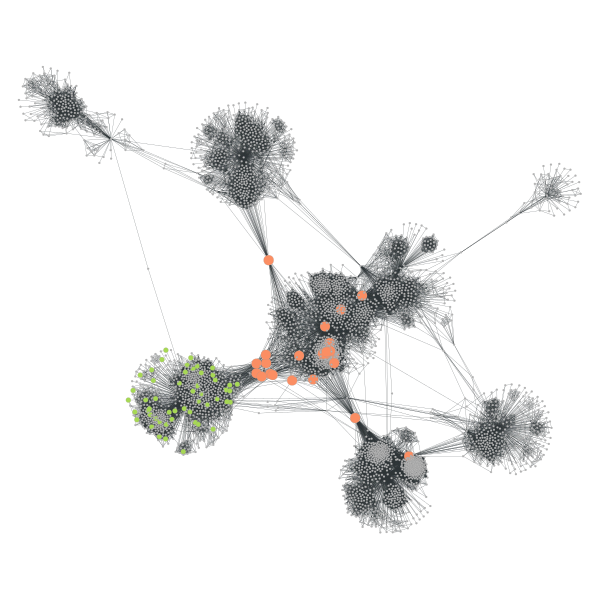

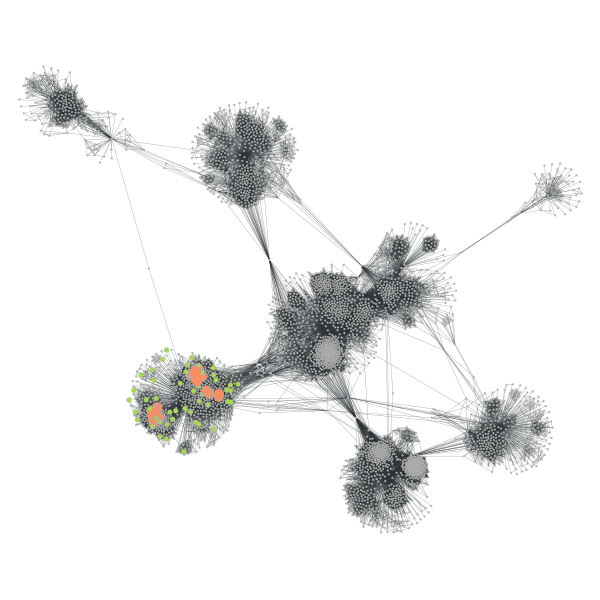

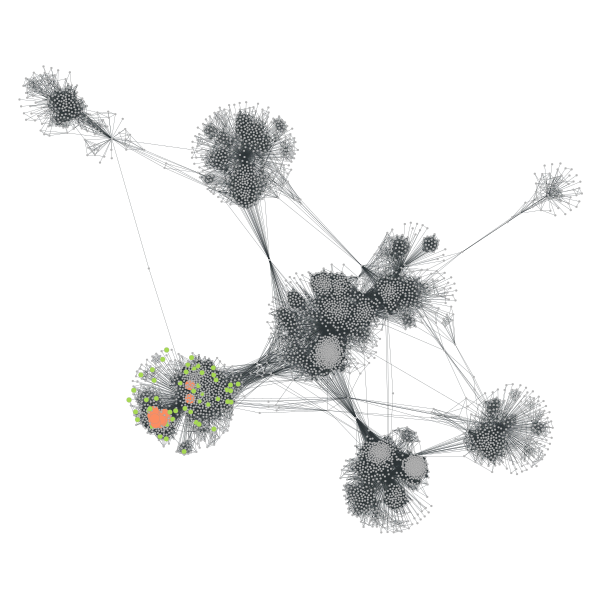

In [22]:
illustrate(random_best_cascade_id, 'random_best')
illustrate(prederror_best_cascade_id, 'prediction_error_best')
illustrate(similar_cascade_id, 'equally_good')

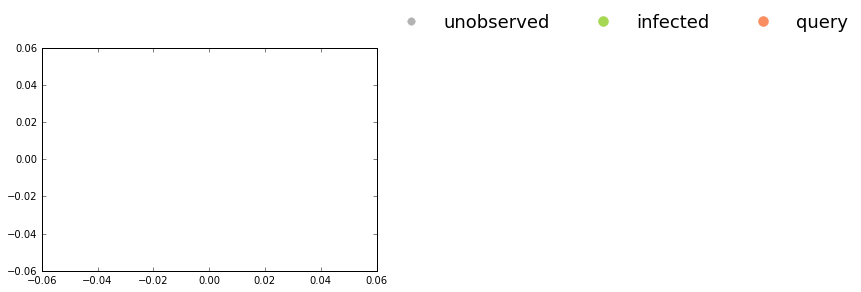

In [41]:
# plot_legend

import matplotlib.pyplot as plt

colors = [pal[DEFAULT_COLOR_ID], pal[OBS_COLOR_ID], pal[QUERY_COLOR_ID]]
sizes = [15, 20, 20]
f = lambda m,c, size: plt.plot([],[],marker=m, color=c, markersize=size, ls="none")[0]
handles = [f(".", colors[i], sizes[i]) for i in range(3)]
labels = ['unobserved', 'infected', 'query']
legend = plt.legend(handles, labels, loc=3, 
                    ncol=3, numpoints=1,
                    bbox_to_anchor=(1,1),
                    fontsize=18,
                    framealpha=1, frameon=False)


def export_legend(legend, filename="legend.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend, fig_root_dir + '/legend.png')
plt.show()